In [18]:
import string
import re
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from textwrap import wrap
from collections import defaultdict
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import rc
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import time
from preprocessing.nlp import preprocess
from preprocessing.tratamento import filter_data

RANDOM_SEED = 15
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
MAX_LEN = 156
BATCH_SIZE = 16
EPOCHS = 10

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [19]:


class TCEDataset(Dataset):
    def __init__(self, empenho, targets, tokenizer, max_len):
        self.empenho = empenho
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.empenho)

    def __getitem__(self, item):
        empenho = str(self.empenho[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            empenho,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'empenho_text': empenho,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TCEDataset(
        empenho=df.empenho.to_numpy(),
        targets=df.encodedNatureza.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
    )


class NaturezaClassifier(nn.Module):
    def __init__(self, n_classes):
        super(NaturezaClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(bert_output['pooler_output'])
        return self.out(output)


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    predictions = []
    real_values = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        predictions.extend(preds)
        real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    macro = f1_score(real_values, predictions, average='macro')
    micro = f1_score(real_values, predictions, average='micro')
    return correct_predictions.double() / n_examples, np.mean(losses), macro, micro


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            predictions.extend(preds)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    macro = f1_score(real_values, predictions, average='macro')
    micro = f1_score(real_values, predictions, average='micro')
    return correct_predictions.double() / n_examples, np.mean(losses), macro, micro



In [20]:
df = filter_data(
    '../data/dadosTCE.csv',
    '../data/norel.xlsx'
)
df = df[['empenho_historico', 'natureza_despesa_cod']]
df.columns = ['empenho', 'natureza']
df.empenho = df.empenho.apply(preprocess)

lb = LabelEncoder()
df['encodedNatureza'] = lb.fit_transform(df.natureza)

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

df_train, df_val = train_test_split(
    df,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=df.natureza
)
# df_val, df_test = train_test_split(
#     df_val,
#     test_size=0.5,
#     random_state=RANDOM_SEED,
#     stratify=df_test.natureza
# )

train_data_loader = create_data_loader(
    df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247896 entries, 0 to 247895
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   empenho          247896 non-null  object
 1   natureza         247896 non-null  object
 2   encodedNatureza  247896 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.7+ MB


In [22]:
model = NaturezaClassifier(len(lb.classes_))
model = model.to(device)

# model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device(device)))

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)


In [23]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    starting = time.time()
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss, train_macro, train_micro = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(
        f'Train loss {train_loss} accuracy {train_acc} macro {train_macro} micro {train_micro}')
    val_acc, val_loss, val_macro, val_micro = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(
        f'Val   loss {val_loss} accuracy {val_acc} macro {val_macro} micro {val_micro}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_macro'].append(train_macro)
    history['train_micro'].append(train_micro)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_macro'].append(val_macro)
    history['val_micro'].append(val_micro)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
    print(f'{(time.time()-starting)/60}')


Epoch 1/10
----------
Train loss 1.318478096356207 accuracy 0.7291257268321356 macro 0.2953796928550659 micro 0.7291257268321356
Val   loss 0.6629555967361357 accuracy 0.8383466229208407 macro 0.41864676881938906 micro 0.8383466229208407

691.6759706219037
Epoch 2/10
----------
Train loss 0.5707323919614548 accuracy 0.8583159969341947 macro 0.493751918681895 micro 0.8583159969341947
Val   loss 0.5225246343076563 accuracy 0.8668800172114726 macro 0.5417660493874092 micro 0.8668800172114726

692.0185558716456
Epoch 3/10
----------
Train loss 0.43938317174049346 accuracy 0.8836146536273894 macro 0.5757667595076855 micro 0.8836146536273893
Val   loss 0.47636953130914117 accuracy 0.8772337936505802 macro 0.5791176092665644 micro 0.8772337936505802

685.4994743903478
Epoch 4/10
----------
Train loss 0.3676797558601431 accuracy 0.8989667314020297 macro 0.6283685844504749 micro 0.8989667314020297
Val   loss 0.46361524770841656 accuracy 0.8814559830036709 macro 0.616022082093047 micro 0.8814559

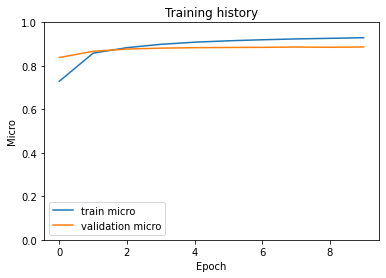

In [24]:

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Acc.png')

plt.cla()
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Loss.png')

plt.cla()
plt.plot(history['train_macro'], label='train macro')
plt.plot(history['val_macro'], label='validation macro')
plt.title('Training history')
plt.ylabel('Macro')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Macro.png')

plt.cla()
plt.plot(history['train_micro'], label='train micro')
plt.plot(history['val_micro'], label='validation micro')
plt.title('Training history')
plt.ylabel('Micro')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Micro.png')


In [26]:
test_acc, _, _, _ = eval_model(
    model,
#     test_data_loader,
    val_data_loader,
    loss_fn,
    device,
    len(df_test)
)
print(test_acc.item())


def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["empenho_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    val_data_loader
)

print('Test Classification Report')
print(classification_report(y_test, y_pred))


0.8868345681668437
Test Classification Report
              precision    recall  f1-score   support

           0       0.69      0.93      0.80       183
           1       0.71      0.89      0.79        19
           2       0.98      0.90      0.93       229
           3       0.95      1.00      0.97        35
           4       0.81      0.91      0.86       394
           5       0.95      0.90      0.93        62
           6       0.62      0.90      0.73       172
           7       0.89      0.89      0.89        19
           8       1.00      1.00      1.00        13
           9       0.98      0.99      0.99       180
          10       0.78      0.97      0.86       229
          11       0.65      0.99      0.78       124
          12       0.35      0.30      0.32        20
          13       0.75      0.99      0.85       210
          14       0.00      0.00      0.00         1
          15       0.97      0.99      0.98       179
          16       0.86      1.00  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
